# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.637284,True,7.923262
1,2.002730,True,10.278331
2,2.218463,True,10.735905
3,2.041385,True,10.419662
4,1.177200,True,9.211657
...,...,...,...
995,2.084789,True,10.864462
996,0.301008,True,6.174388
997,1.010671,True,8.414973
998,0.620033,True,8.476532


<AxesSubplot: xlabel='v0'>

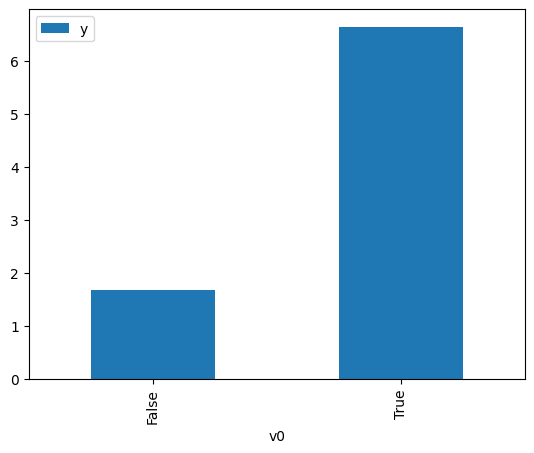

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

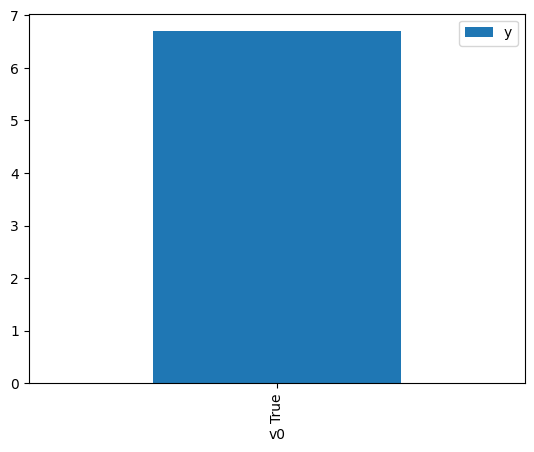

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.422300,False,-2.121897,0.590347,1.693920
1,1.931941,False,4.574001,0.084440,11.842660
2,-0.205387,False,-0.444295,0.528002,1.893933
3,-0.683738,False,-1.308948,0.661652,1.511370
4,0.601662,False,1.670238,0.303600,3.293805
...,...,...,...,...,...
995,1.143572,False,2.643427,0.188015,5.318738
996,-1.270351,False,-3.826237,0.795045,1.257790
997,1.136317,False,2.288365,0.189311,5.282306
998,-0.701848,False,-3.422370,0.666369,1.500670


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.660200,True,7.058766,0.710654,1.407155
1,0.855177,True,7.726555,0.755141,1.324255
2,1.800183,True,11.033382,0.902880,1.107567
3,-2.633953,True,-0.358016,0.049841,20.063887
4,0.665308,True,8.177646,0.711879,1.404733
...,...,...,...,...,...
995,0.452771,True,6.764424,0.658443,1.518735
996,-0.739938,True,2.894201,0.323818,3.088159
997,0.847735,True,8.319765,0.753531,1.327085
998,-0.089163,True,4.466310,0.505895,1.976693


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.977
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                          2.084e+04
Date:                Tue, 07 Mar 2023   Prob (F-statistic):                        0.00
Time:                        16:36:19   Log-Likelihood:                         -1434.7
No. Observations:                1000   AIC:                                      2873.
Df Residuals:                     998   BIC:                                      2883.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.6815      0.037     72.109      0.000       2.609       2.754
x2             5.0029      0.052     95.455      0.000       4.900       5.106
==============================================================================
Omnibus:                        3.623   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.163   Jarque-Bera (JB):                3.506
Skew:                           0.141   Prob(JB):                        0.173
Kurtosis:                       3.066   Cond. No.                         2.41
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""